In [8]:
import http.client
import json
import pprint
import collections

start_date='2019-01-01'
end_date='2030-01-01'

connection = http.client.HTTPSConnection("api.exchangeratesapi.io", timeout=2)
connection.request('GET', """/history?start_at={start}&end_at={end}&base=USD&symbols=BRL""".format(start=start_date, end=end_date))
response = connection.getresponse()
json_content = json.loads(response.read())
rates = json_content["rates"]
# pprint.pprint(rates)

In [9]:
def group_by_month(dictionary):
    output = {}
    for key in dictionary:
        month_key = key[:7]
        day = int(key[8:])
        if month_key in output:
            rate_list = output[month_key]
            rate_list[day] = dictionary[key]['BRL']
            output[month_key] = rate_list
        else:
            output[month_key] = {day: dictionary[key]['BRL']}
    return output

def normalize_values(dictionary, min_value, max_value):
    delta = max_value - min_value
    for key in dictionary:
        value = dictionary[key]
        if (delta != 0):
            dictionary[key] = (value - min_value)/delta
        else:
            dictionary[key] = 1
    return dictionary
        

def make_rates_relative(grouped_rates):
    output = {}
    for key in grouped_rates:
        values = grouped_rates[key]
        min_rate = 10000
        max_rate = -1
        for day_key in values:
            rate = values[day_key]
            if rate < min_rate:
                min_rate = rate
            if rate > max_rate:
                max_rate = rate
        grouped_rates[key] = normalize_values(values, min_rate, max_rate)
    return grouped_rates
            

grouped_values = group_by_month(rates)
normalized_values = make_rates_relative(grouped_values)
# pprint.pprint(normalized_values)

In [10]:
def group_by_day(month_dict):
    output = {}
    for month in month_dict:
        month_value = month_dict[month]
        for day in month_value:
            rate = month_value[day]
            if day in output:
                output[day].append(rate)
            else:
                output[day] = [rate]
    return output

values_per_day = group_by_day(normalized_values)

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import operator
import numpy as np

data = {}
for key in values_per_day:
    value = values_per_day[key]
    data[key] = sum(value)/len(value)

lists = sorted(data.items()) # sorted by key, return a list of tuples

ordered_by_value = sorted(data.items(), key = operator.itemgetter(1),reverse = True)

The Relative Value is between the min and max USD->BRL values in a given month




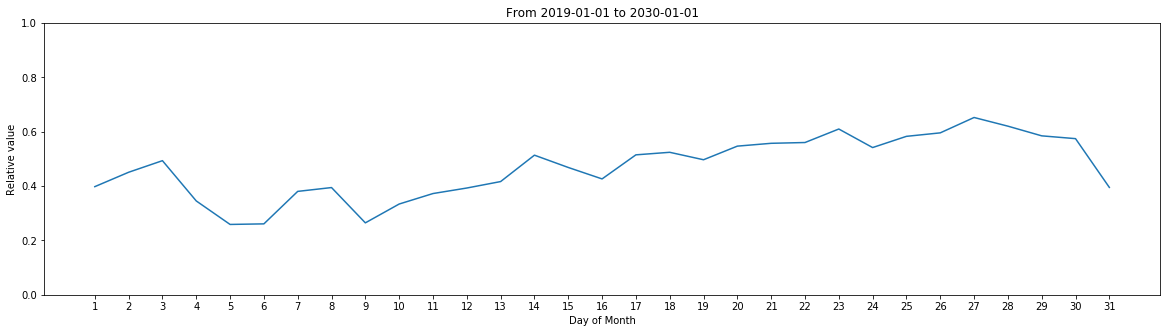

The day with highest value probability is the 27 with a value of 0.6523516063316553
The day with lowest value probability is the 5 with a value of 0.2588796858092467


In [19]:
x, y = zip(*lists) # unpack a list of pairs into two tuples

print('The Relative Value is between the min and max USD->BRL values in a given month\n\n')

plt.figure(figsize=(20,5))
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.plot(x, y)
plt.title(label="From {start} to {end}".format(start=start_date, end=end_date))
plt.ylim((0,1))
plt.ylabel('Relative value')
plt.xlabel('Day of Month')
plt.show()

best_day = ordered_by_value[0]
print('The day with highest value probability is the ' + str(best_day[0]) + ' with a value of ' + str(best_day[1]))
worst_day = ordered_by_value[-1]
print('The day with lowest value probability is the ' + str(worst_day[0]) + ' with a value of ' + str(worst_day[1]))